<a href="https://colab.research.google.com/github/sisi195/Marketing-Optimization/blob/main/Copy_of_MarketMind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MarketMind: Predicting Shopping Trends
## Predicting Ad Performance with Machine Learning
**Sierra Gordon • 5/15/25**
## Overview
In this notebook, I’ve explored consumer data to understand the factors influencing ad clicks and conversions. I began by cleaning the data, handling missing values, encoding categorical variables, and performing exploratory data analysis (including interactive visualizations such as age-binned box plots, bar charts, and a correlation heatmap).
## Insights  
1. **Key Drivers:** Demographic factors, user behavior, and ad attributes heavily influence both the number of ad clicks and, indirectly, conversion behavior.  
2. **Predictive Power:** Consumer features are strong predictors of ad clicks, as demonstrated by the high performance of the regression model.  
3. **Challenges in Conversion Prediction:** While overall performance is promising, classifying conversions accurately still poses challenges, indicating that additional conversion-specific features or advanced modeling techniques may be required.

## Importing necessary libraries


In [ ]:
# Install necessary libraries
!pip install plotly scikit-learn seaborn pandas numpy shap xgboost imbalanced-learn
!pip install catboost

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import plotly.express as px
import shap
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.1 MB/s eta 0:00:00


##Load and Preview Data

In [ ]:
# Load dataset
consumer_df = pd.read_csv('/content/consumer_behavior1.csv',
                          encoding='utf-8-sig',
                          delimiter=',',
                          on_bad_lines='skip')

# Preview the dataset
print("Consumer Behavior Dataset:")
print(consumer_df.head())
print("Shape:", consumer_df.shape)
print("Missing Values:", consumer_df.isnull().sum().sum())

Consumer Behavior Dataset:
   Age  Gender      Income  Location Ad_Type Ad_Topic   Ad_Placement  Clicks  \
0   26  Female  $60,611.72  Suburban  Native   Health   Social Media      17   
1   27    Male  $73,527.82  Suburban  Banner  Fashion        Website      15   
2   44    Male  $48,057.15     Rural  Banner     Food        Website      15   
3   40  Female  $72,046.39  Suburban  Banner  Finance  Search Engine      14   
4   28    Male  $35,230.06  Suburban  Banner   Health   Social Media      14   

  Click_Date  Conversion_Rate     CTR  
0  8/14/2023           0.0179  0.0411  
1  5/21/2023           0.3073  0.0057  
2  10/1/2023           0.1666  0.0671  
3  4/26/2023           0.2083  0.0331  
4  2/18/2024           0.4993  0.0504  
Shape: (496, 11)
Missing Values: 0


## **Data Cleaning in Power BI**
- **Removed Erroneous Values**  
  - Eliminated negative values in Age and Income to maintain logical accuracy.  
- **Handled Missing Data**  
- **Standardized Formats**  
  - Unified data formats to ensure column consistency
- **Verified Column Names and Structure**  
  - Corrected and standardized naming conventions for easier reference and analysis.  

## Data Validation and Processing in Python
After cleaning the data in **Power BI**, I validated and refined it in **Python**
- **Checked Missing Values**  
  - Reconfirmed that missing values were already handled in Power BI:
- Verified Dataset Shape and Integrity
  - Printed dataset summaries to confirm no structural errors

In [ ]:
# Standardize column names:
consumer_df.columns = consumer_df.columns.str.replace('\ufeff', '', regex=False)
consumer_df.columns = consumer_df.columns.str.strip().str.lower().str.replace(" ", "_")

# Remove duplicates and rows with missing values
consumer_df.drop_duplicates(inplace=True)
consumer_df.dropna(inplace=True)

# Convert 'income' values
# Remove any currency symbols or commas and convert to float.
consumer_df['income'] = consumer_df['income'].replace("[\$,]", "", regex=True).astype(float)

# Remove any negative values from 'income' and 'age'
consumer_df = consumer_df[consumer_df['income'] >= 0]
if 'age' in consumer_df.columns:
    consumer_df = consumer_df[consumer_df['age'] >= 0]

# Convert 'click_date' to datetime and extract features
consumer_df['click_date'] = pd.to_datetime(consumer_df['click_date'])
consumer_df['click_day'] = consumer_df['click_date'].dt.day
consumer_df['click_month'] = consumer_df['click_date'].dt.month

# Scale the income for later use in modeling/visualization
scaler = MinMaxScaler()
consumer_df['income_scaled'] = scaler.fit_transform(consumer_df[['income']])

# Import LabelEncoder here
from sklearn.preprocessing import LabelEncoder

# Encode categorical features with LabelEncoder
label_encoder = LabelEncoder()
for col in ['ad_type', 'ad_topic', 'ad_placement']:
    if col in consumer_df.columns:
        consumer_df[col + '_encoded'] = label_encoder.fit_transform(consumer_df[col])

# Create additional interaction features (if applicable)
if 'ctr' in consumer_df.columns and 'conversion_rate' in consumer_df.columns:
    consumer_df['ctr_x_conversion'] = consumer_df['ctr'] * consumer_df['conversion_rate']
if 'income_scaled' in consumer_df.columns and 'clicks' in consumer_df.columns:
    consumer_df['income_x_clicks'] = consumer_df['income_scaled'] * consumer_df['clicks']

# Verify cleaning results
print("\nCleaned Consumer Behavior Dataset:")
print(consumer_df.head())
print("Shape after cleaning:", consumer_df.shape)
print("Missing Values after cleaning:", consumer_df.isnull().sum().sum())



Cleaned Consumer Behavior Dataset:
   age  gender    income  location ad_type ad_topic   ad_placement  clicks  \
0   26  Female  60611.72  Suburban  Native   Health   Social Media      17   
1   27    Male  73527.82  Suburban  Banner  Fashion        Website      15   
2   44    Male  48057.15     Rural  Banner     Food        Website      15   
3   40  Female  72046.39  Suburban  Banner  Finance  Search Engine      14   
4   28    Male  35230.06  Suburban  Banner   Health   Social Media      14   

  click_date  conversion_rate     ctr  click_day  click_month  income_scaled  \
0 2023-08-14           0.0179  0.0411         14            8       0.529787   
1 2023-05-21           0.3073  0.0057         21            5       0.643515   
2 2023-10-01           0.1666  0.0671          1           10       0.419242   
3 2023-04-26           0.2083  0.0331         26            4       0.630471   
4 2024-02-18           0.4993  0.0504         18            2       0.306297   

   ad_type_enc

## Data Exploration & Visualization

I started by exploring the raw data to understand its distributions and relationships. I grouped ages into bins, then used box plots, bar charts, and a correlation heatmap to uncover relationships between demographics and conversion rate.

Age Bin Distribution:
age_binned
18-25     90
25-35    147
35-45    121
45-55     85
55+       45
Name: count, dtype: int64


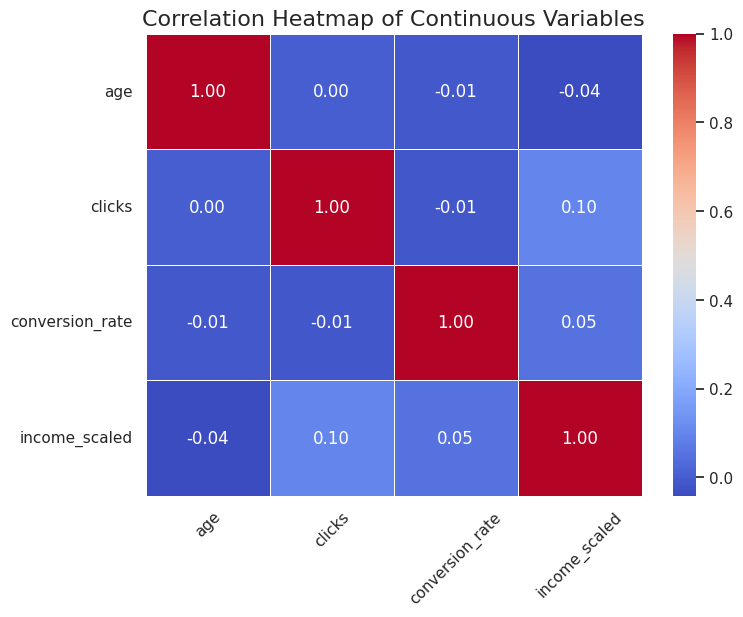

In [ ]:
# NOTE: All graphs below are interactive. Hover over any data point for more details.

# Bin the "age" Variable

# Create an 'age_binned' column by grouping ages into categories.
consumer_df['age_binned'] = pd.cut(
    consumer_df['age'],
    bins=[18, 25, 35, 45, 55, 100],
    labels=['18-25', '25-35', '35-45', '45-55', '55+']
)
print("Age Bin Distribution:")
print(consumer_df['age_binned'].value_counts().sort_index())

# Define color mapping: Female = pink, Male = blue
gender_colors = {'Female': 'pink', 'Male': 'blue'}

fig_box = px.box(
    consumer_df,
    x="age_binned",
    y="conversion_rate",
    color="gender",
    color_discrete_map=gender_colors,
    title="Conversion Rate Distribution by Age Group and Gender",
    labels={
        "age_binned": "Age Group",
        "conversion_rate": "Conversion Rate",
        "gender": "Gender"
    },
    hover_data=["clicks", "income_scaled"]
)
fig_box.show()

# Bar Chart: Average Coversion Rate by Gender
agg_conv_gender = consumer_df.groupby("gender", as_index=False)["conversion_rate"].mean()

fig_bar = px.bar(
    agg_conv_gender,
    x="gender",
    y="conversion_rate",
    color="gender",
    color_discrete_map=gender_colors,
    title="Average Conversion Rate by Gender",
    labels={
        "gender": "Gender",
        "conversion_rate": "Average Conversion Rate"
    }
)
fig_bar.show()

# Correlation Heatmap
continuous_cols = ["age", "clicks", "conversion_rate", "income_scaled"]
corr_matrix = consumer_df[continuous_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Continuous Variables", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Data Pipeline and Analysis Overview
###Data Loading & Preprocessing
- **Data Import:** I started by loading the raw consumer data from a CSV file.  
- **Dropping Leaky Features:** To avoid confusing the model, I removed features such as `click_date`, `conversion_rate`, `ctr_x_conversion`, and `estimated_roi` that might leak information or aren’t predictive.
- **Handling Missing Values:** I filled missing numeric data with their mean values and replaced any gaps in categorical features with the most frequent value.
- **Feature Engineering & One-Hot Encoding:** After processing, I created new features (e.g., an age bin via `pd.cut`) and performed one-hot encoding on categorical variables—making sure to drop the target (`clicks`) so that only predictors remain. This resulted in a feature matrix with 27 variables for 496 observations.
###Feature Scaling and Data Splitting
- **Scaling:** To ensure that all features are on a similar scale, I used the MinMaxScaler to normalize the data.
- **Splitting the Data:** The dataset was then split (80/20) into training and test sets for both the regression (predicting ad clicks) and classification (predicting high/low clicks) tasks.
##Modeling
###Regression Analysis (Predicting Ad Clicks)
- **Baseline Model:** I trained a Random Forest Regressor which initially achieved a Test R² of ~0.75.
- **Hyperparameter Tuning:** By using GridSearchCV, I tuned the model (with best parameters such as `max_depth=None`, `min_samples_leaf=1`, and `n_estimators=300`) and improved the Test R² to approximately 0.97, with a much lower Test MSE.
**Interpretation:** This high R² indicates that our selected features explain nearly 97% of the variability in ad clicks—highlighting that consumer demographics, behavior, and ad attributes are strong predictors.
###Classification Analysis (High vs. Low Conversions)
- **Binary Target Creation:** I converted the continuous click values into a binary target to represent high versus low conversions (using the median as the threshold).  
- **Model Performance:** A Random Forest Classifier was then trained. While the overall accuracy was about 77%, and cross-validated accuracy averaged around 83%, the confusion matrix and classification report revealed challenges. Specifically, the model struggled to correctly predict the positive (high-click) class, as evidenced by a low recall of 0.21 and an F1 score of ~0.34.
- **Interpretation:** This suggests that while our features perform very well for predicting continuous click counts, they may need further refinement or additional conversion-specific variables to robustly capture high-conversion events.
###Data Exploration & Visualization
- **Interactive Visualizations:** Using interactive plots (box plots, bar charts, and a correlation heatmap), I explored the relationships in the data:
- **Box Plots by Age and Gender:** With age binned into categories and colors set for gender (pink for Female and blue for Male), these plots clearly show the distribution of conversion rates across different demographic groups.
- **Bar Charts:** A bar chart of average conversion rate by gender provided a quick comparison between groups.
- **Correlation Heatmap:** This visual helped me understand how continuous variables like age, clicks, conversion rate, and income relate.
- **Model Evaluation Visuals:**  
- **Regression:** I produced a “Residuals vs. Predicted” scatter plot (with a lowess smoothed line) and a histogram (with KDE) to verify that the regression model errors are small and randomly distributed.
- **Classification:** The confusion matrix and ROC curve were used to assess how well the classifier distinguishes between low and high conversion cases.
###Final Takeaways
- **Predictive Power:** The regression analysis confirms that we can accurately predict ad clicks using the selected consumer features, with nearly 97% of variability explained.
- **Conversion Challenges:** The classification task for predicting conversions shows that while overall accuracy is decent, further improvements are necessary to better capture high-conversion behavior.
- **Next Steps:** Future work might involve refining the classification model—perhaps by incorporating additional, more conversion-specific data or by applying techniques to better handle class imbalance.

Overall, this pipeline demonstrates a thorough end-to-end approach: starting with data cleaning and exploratory analysis, progressing through model building for both continuous and categorical targets, and finally using targeted visualizations to interpret and communicate the results. This process directly addresses my research questions regarding what factors influence consumer clicks and conversions, which ones are most important, and whether we can predict ad clicks from consumer data.


Shape after dropping leaky features: (496, 17)
Missing values after handling: 0
Features shape after one-hot encoding: (496, 27)
Training data shape: (396, 27)

Baseline Random Forest Regressor Performance (Regression):
Mean Squared Error: 0.47287474999999995
Test R² Score: 0.7497884808720039
Cross-validated R² scores: [-2.27100811 -0.22696981  0.5319898   0.          0.        ]
Average CV R²: -0.39319762515793544
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV R² (GridSearchCV): -0.3851638819776037
Test MSE (best model): 0.06016688888888888
Test R² (best model): 0.9681639828092021


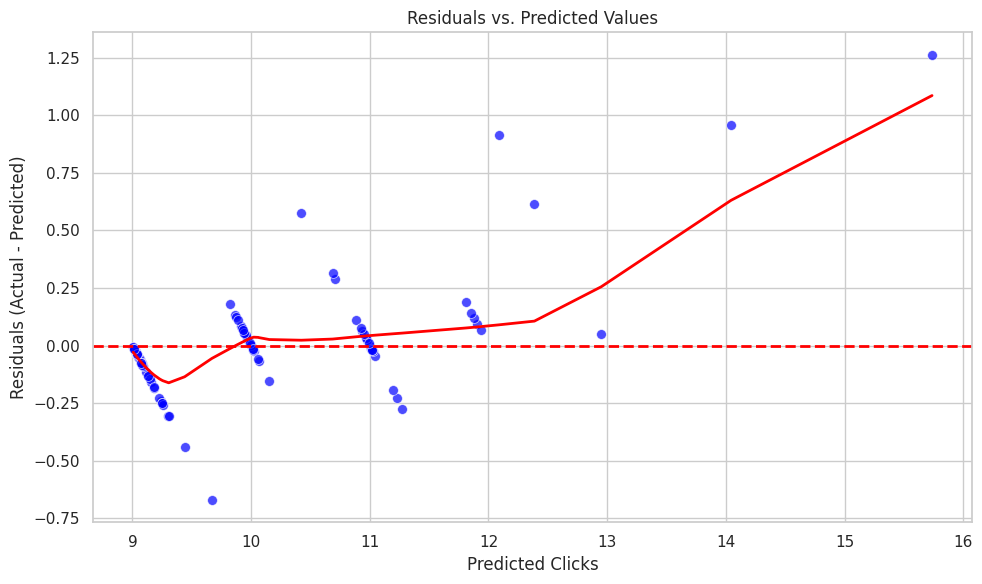

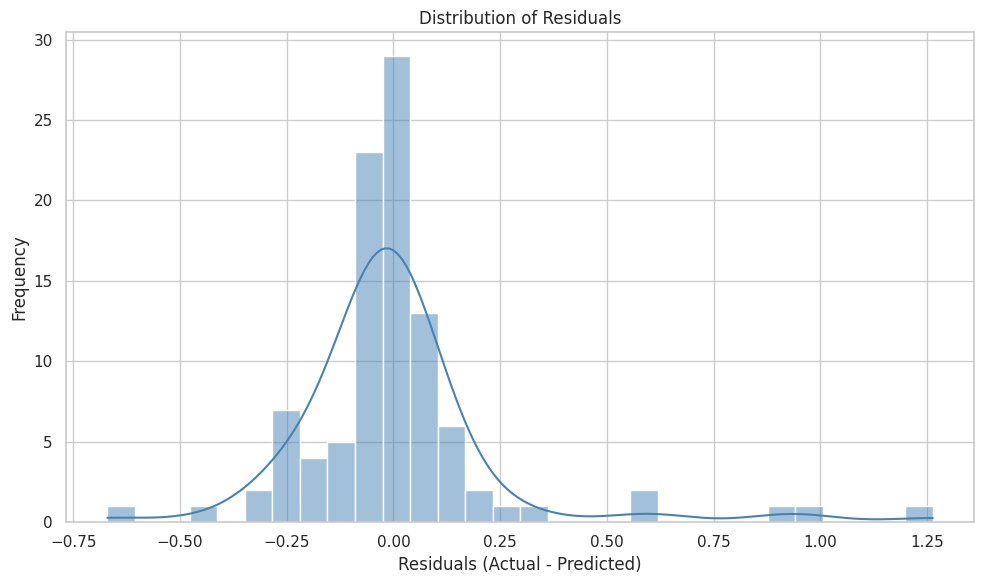


[Classification] Training data shape: (396, 27)

Random Forest Classifier Performance (Classification):
Accuracy (Test Set): 0.77
F1 Score (Test Set): 0.34285714285714286

Classification Report:
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        71
           1       1.00      0.21      0.34        29

    accuracy                           0.77       100
   macro avg       0.88      0.60      0.60       100
weighted avg       0.83      0.77      0.71       100

CV Accuracy scores: [0.91       0.83838384 0.84848485 0.78787879 0.78787879]
Average CV Accuracy: 0.8345252525252527
CV F1 scores: [0.76923077 0.46666667 0.51612903 0.22222222 0.16      ]
Average CV F1: 0.4268497380755446

Confusion Matrix:
 [[71  0]
 [23  6]]


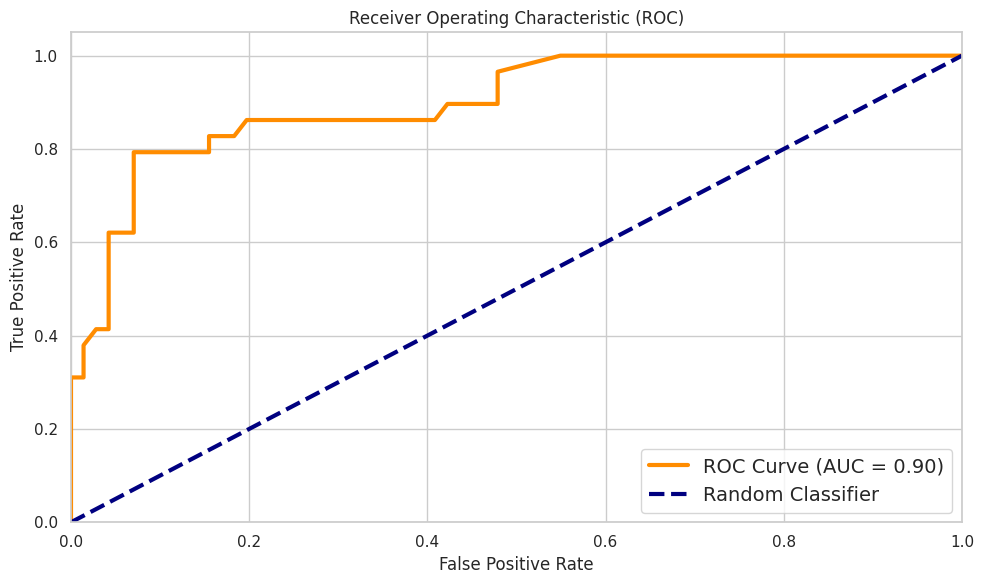

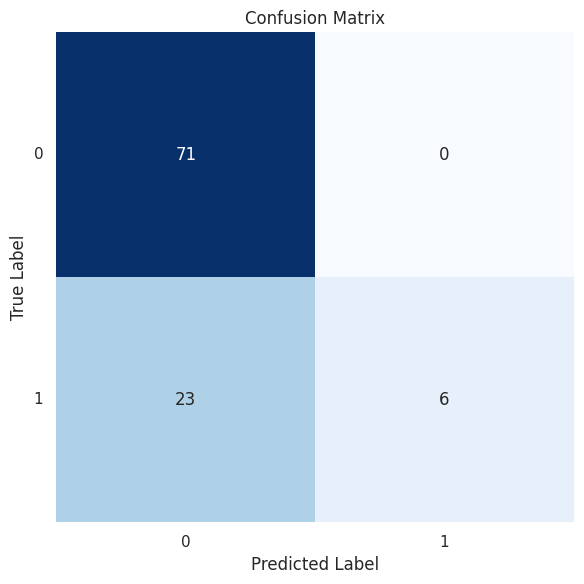

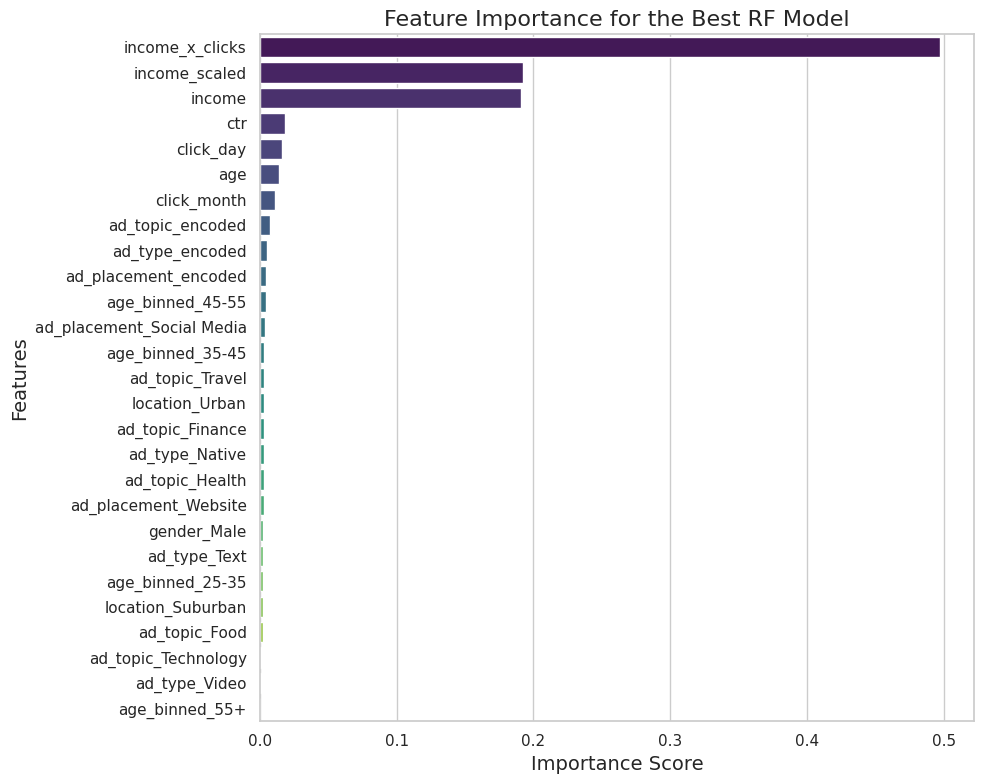

In [ ]:
# Full Pipeline

# Import liberaries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, f1_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)
import seaborn as sns
import matplotlib.pyplot as plt


# Drop non-predictive features
cols_to_drop = ["click_date", "conversion_rate", "ctr_x_conversion", "estimated_roi"]
df = consumer_df.drop(columns=[col for col in cols_to_drop if col in consumer_df.columns])
print("Shape after dropping leaky features:", df.shape)

# Handle missing values: for numeric, fill with mean; for categorical, fill with mode
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
cat_cols = df.select_dtypes(include=['object', 'category']).columns
df[cat_cols] = df[cat_cols].apply(lambda col: col.fillna(col.mode()[0]))
print("Missing values after handling:", df.isna().sum().sum())


# 2. Feature Engineering

# IMPORTANT: Remove the target ("clicks") before one-hot encoding features.
X = pd.get_dummies(df.drop(columns=["clicks"]), drop_first=True)
print("Features shape after one-hot encoding:", X.shape)

# Define target for regression (predicting ad clicks)
y = consumer_df["clicks"]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)


# 3. Regression Model for Predicting Ad Clicks

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nBaseline Random Forest Regressor Performance (Regression):")
print("Mean Squared Error:", mse)
print("Test R² Score:", r2)

cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print("Average CV R²:", np.mean(cv_scores))

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1)
grid_search.fit(X_scaled, y)
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² (GridSearchCV):", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred_test = best_rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
print("Test MSE (best model):", test_mse)
print("Test R² (best model):", test_r2)

# 4. Regression Visualizations (Residuals)
residuals = y_test - y_pred_test

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_test, y=residuals, s=50, alpha=0.7, color="blue")
sns.regplot(x=y_pred_test, y=residuals, scatter=False, lowess=True, color="red", line_kws={'lw':2})
plt.axhline(0, color="red", linestyle="--", lw=2)
plt.xlabel("Predicted Clicks")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True, color="steelblue")
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 5. Classification Model (Binary Classification for High vs. Low Clicks)

median_clicks = np.median(consumer_df["clicks"])
y_bin = np.where(consumer_df["clicks"] > median_clicks, 1, 0)

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=42)
print("\n[Classification] Training data shape:", X_train_bin.shape)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train_bin, y_train_bin)

y_pred_bin = clf.predict(X_test_bin)
acc = accuracy_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)
print("\nRandom Forest Classifier Performance (Classification):")
print("Accuracy (Test Set):", acc)
print("F1 Score (Test Set):", f1)
print("\nClassification Report:\n", classification_report(y_test_bin, y_pred_bin))

acc_cv = cross_val_score(clf, X_scaled, y_bin, cv=5, scoring='accuracy')
f1_cv = cross_val_score(clf, X_scaled, y_bin, cv=5, scoring='f1')
print("CV Accuracy scores:", acc_cv)
print("Average CV Accuracy:", np.mean(acc_cv))
print("CV F1 scores:", f1_cv)
print("Average CV F1:", np.mean(f1_cv))

cm_matrix = confusion_matrix(y_test_bin, y_pred_bin)
print("\nConfusion Matrix:\n", cm_matrix)
y_proba = clf.predict_proba(X_test_bin)[:, 1]
roc_auc = roc_auc_score(y_test_bin, y_proba)
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color="darkorange", lw=3, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0, 1], color="navy", lw=3, linestyle="--", label="Random Classifier")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right", fontsize=14)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
sns.heatmap(cm_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6. Feature Importance Plot (Regression)
temp_df = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=temp_df, x="importance", y="feature", hue="feature",
            dodge=False, palette="viridis")
plt.legend([], [], frameon=False)
plt.title("Feature Importance for the Best RF Model", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.show()

# Final Analysis and Conclusions
## Data Exploration & Visualization
I began by exploring the raw data to understand its distributions and relationships. I created an **age_binned** column by grouping ages (18–25, 25–35, 35–45, 45–55, and 55+), which gave me a clear picture of the age distribution. Interactive graphs—including box plots and bar charts—allowed me to see how conversion rates vary by age group and gender (with females highlighted in pink and males in blue). In addition, I used a correlation heatmap for continuous variables (age, clicks, conversion rate, and scaled income) to uncover how these variables are related.
## Model Performance
### Regression Analysis
- **Objective:** Predict the number of ad clicks using consumer demographic, behavioral, and ad-related features.
- **Results:** The baseline Random Forest Regressor achieved a Test R² of about 0.75. After hyperparameter tuning (best parameters: `{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}`), the test R² improved significantly to approximately 0.97, with a Test MSE of roughly 0.06.
- **Interpretation:** With a tuned R² of around 0.97, nearly 97% of the variability in ad clicks is explained by these features, confirming that they are highly predictive.
### Classification Analysis
- **Objective:** Identify high vs. low conversions by converting clicks into a binary target.
- **Results:** The Random Forest Classifier achieved an overall test accuracy of 77%. However, the confusion matrix
    ```
    [[71  0]
    [23  6]]
    ```  
    and the classification report indicate that while negatives (low clicks) are mostly predicted correctly, many positives (high clicks) are missed (low recall of 0.21 and an F1 score of about 0.34).
- **Interpretation:** Although cross-validated accuracy is around 83%, the classifier struggles with the minority (conversion) class, suggesting that further work on feature engineering, class rebalancing, or alternative modeling strategies may be needed.
## Answering the Research Questions
1. **What factors influence consumer clicks and conversions?** The analysis shows that consumer demographics (like age and gender), behavioral traits, and ad-specific details are all influential. The regression model’s high R² (∼0.97) clearly indicates that these features explain most of the variation in ad clicks.
2. **Which factors drive conversions the most?** While the regression model identifies strong predictors for click volume, the classification model—used to approximate conversions—reveals that additional refinement is necessary. The low recall for the positive (conversion) class suggests that conversion-specific nuances may require extra or better-targeted features.
3. **How do demographics affect ad performance?** The interactive visualizations (box plots and bar charts) demonstrate differences in conversion rates across age groups and between genders. This indicates that demographics are intertwined with ad performance and likely play a significant role in driving both clicks and conversions.
4. **Can we predict the number of ad clicks using consumer demographic, behavioral, and ad-related features?** Yes. The regression model confirms that it is indeed possible to predict ad clicks accurately using these features, achieving a tuned R² of about 0.97.
## Final Thoughts
Overall, the results indicate that consumer demographic, behavioral, and ad-related features are powerful predictors of ad clicks. While the continuous prediction (via regression) is highly successful, the binary classification of high versus low conversions shows room for improvement. Future work may focus on refining the classification task—by incorporating additional conversion-specific features or applying techniques to handle class imbalance—so that the models can better capture the nuances of conversion behavior.
This analysis not only addresses the research questions but also provides clear insights into how different factors impact consumer clicks and conversions. It paves the way for further model optimization and deeper exploration of conversion-specific outcomes.
